In [1]:
import torch 
import torch_geometric
from torch_geometric.loader import DataLoader
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from tqdm import tqdm
from dataset import *
from model import *
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cpu")

In [2]:
torch_geometric.seed_everything(23)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
data = MoC_c_dir(root ='../Data/coords_direction', max_d = 3.2, max_n = 26)
print("Dataset type: ", type(data))
print("Dataset node features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Processing...


Dataset type:  <class 'dataset.MoC_c_dir'>
Dataset node features:  5
Dataset target:  197
Dataset length:  <bound method MoC_c_dir.len of MoC_c_dir(200)>
Dataset sample:  Data(x=[48, 5], edge_index=[2, 662], edge_attr=[662, 6], y=[1], file='1')
Sample  nodes:  48
Sample  edges:  662


Done!


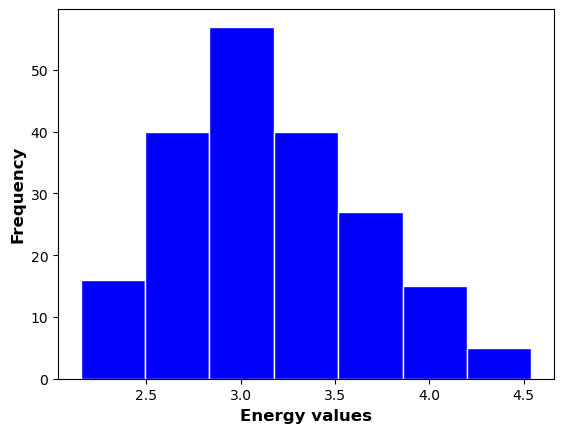

In [5]:
plt.plot(figsize =(12, 8))
plt.hist([torch.squeeze(data[i].y) for i in range(len(data))], bins = 7, color = 'blue', edgecolor='white')
plt.xlabel('Energy values', fontweight ='bold', fontsize = 12)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 12)
plt.show()

In [6]:
x = [data[i].x.numpy() for i in range(data.len())]
x = np.array(x)
y = [data[i].y.numpy() for i in range(data.len())]
y = np.array(y)

In [7]:
limits = np.linspace(np.min(y), np.max(y), num=8)
y_cat = [0]*len(y)
y_cat = np.expand_dims(y_cat, axis = 1)
y_cat = np.array(y_cat)

In [8]:
y_cat[np.where((y >= limits[0]) & (y <limits[1]))[0]] = 0
y_cat[np.where((y >= limits[1]) & (y <limits[2]))[0]] = 1
y_cat[np.where((y >= limits[2]) & (y <limits[3]))[0]] = 2
y_cat[np.where((y >= limits[3]) & (y <limits[4]))[0]] = 3
y_cat[np.where((y >= limits[4]) & (y <limits[5]))[0]] = 4
y_cat[np.where((y >= limits[5]) & (y <limits[6]))[0]] = 5
y_cat[np.where((y >= limits[6]) & (y <= limits[7]))[0]] = 6
y_cat = y_cat.astype(int)

In [9]:
folds = StratifiedKFold(n_splits=5, shuffle=True)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, y_cat)):
    train_idx.append(train)
    test_idx.append(test)

In [10]:
model = GCN_loop(data.num_features, embedding_size = 64, gnn_layers = 3, improved=False)
print(model)
print(model.forward)
print("Number of parameters: ", count_parameters(model))

GCN_loop(
  (initial_conv): GCNConv(5, 64)
  (conv_layers): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)
<bound method GCN_loop.forward of GCN_loop(
  (initial_conv): GCNConv(5, 64)
  (conv_layers): ModuleList(
    (0-1): 2 x GCNConv(64, 64)
  )
  (out): Linear(in_features=128, out_features=1, bias=True)
)>
Number of parameters:  8833


In [11]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma = 0.995)

In [12]:
kfold_idx = 2

In [13]:
train_loader = DataLoader(data[train_idx[kfold_idx]], batch_size = 20, shuffle = True) 
test_loader = DataLoader(data[test_idx[kfold_idx]], batch_size = 10, shuffle = False) 

In [14]:
test_idx[kfold_idx]

array([  0,   1,   4,   9,  17,  28,  37,  40,  53,  55,  62,  81,  83,
        86,  88,  92,  99, 102, 103, 106, 112, 113, 115, 131, 141, 142,
       145, 147, 149, 159, 160, 161, 162, 173, 174, 182, 186, 187, 189,
       197])

In [15]:
train_y = [data[train_idx[kfold_idx]][i].y for i in range(len(data[train_idx[kfold_idx]]))]
test_y = [data[test_idx[kfold_idx]][i].y for i in range(len(data[test_idx[kfold_idx]]))]

print(f'The minimum training value is: {min(train_y)}, and the maximum is {max(train_y)}')
print(f'The minimum test value is: {min(test_y)}, and the maximum is {max(test_y)}')

The minimum training value is: tensor([2.1520], dtype=torch.float64), and the maximum is tensor([4.5407], dtype=torch.float64)
The minimum test value is: tensor([2.3316], dtype=torch.float64), and the maximum is tensor([4.2224], dtype=torch.float64)


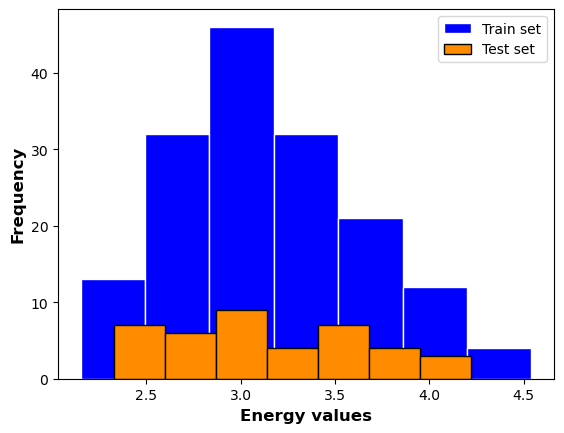

In [16]:
plt.plot(figsize = (12,8))
plt.hist(y[train_idx[kfold_idx]], 7, color = 'blue', label='Train set', edgecolor='white')
plt.hist(y[test_idx[kfold_idx]], 7, color = 'darkorange', label='Test set', edgecolor='black')
plt.xlabel('Energy values', fontweight ='bold', fontsize = 12)
plt.ylabel('Frequency', fontweight ='bold', fontsize = 12)
plt.legend()
plt.show()

In [17]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    for batch in train_loader:

        # Use GPU
        batch.to(device)

        # Reset gradients
        optimiser.zero_grad()

        # Passing the node features and the connection info
        pred = model(batch.x.float(),  
                        batch.edge_index,
                        batch.batch)
        
        # Calculating the loss and gradients
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))
        loss.backward()

        # Update using the gradients
        optimiser.step() 

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_y.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 


    return torch.tensor(total_loss/step), all_preds, all_labels

In [18]:
def test (epoch):
    
    all_preds = []
    all_labels = []
    total_loss = 0
    step = 0

    for batch in test_loader:

        batch.to(device)
        pred = model(batch.x.float(),  
                        batch.edge_index, 
                        batch.batch)
        
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()

    return torch.tensor(total_loss/step), all_preds, all_labels

In [19]:
loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []

epochs = 501

for epoch in range (epochs):
            # Training
            model.train()
            loss, pred, label = train(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if epoch % 5 == 0:
                loss_train.append(loss) 

            if epoch % 100 == 0:
                   print(f"Epoch {epoch} | Train Loss {loss}")
                   pred_train.append(pred)
                   labels_train.append(label)

            # Testing
            model.eval()
            if epoch % 5 == 0:
                loss, pred, label = test(epoch=epoch)
                loss = loss.detach().cpu().numpy() 

                if epoch % 10 == 0:
                    loss_test.append(loss)

                if epoch % 100 == 0:
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    pred_test.append(pred)
                    labels_test.append(label)

            scheduler.step()



Epoch 0 | Train Loss 0.9699611663818359
Epoch 0 | Test Loss 0.5706003308296204
Epoch 100 | Train Loss 0.448600172996521
Epoch 100 | Test Loss 0.45618146657943726
Epoch 200 | Train Loss 0.313664972782135
Epoch 200 | Test Loss 0.4275304675102234
Epoch 300 | Train Loss 0.2584353983402252
Epoch 300 | Test Loss 0.37673455476760864
Epoch 400 | Train Loss 0.231185182929039
Epoch 400 | Test Loss 0.37123799324035645
Epoch 500 | Train Loss 0.20774871110916138
Epoch 500 | Test Loss 0.3876238167285919


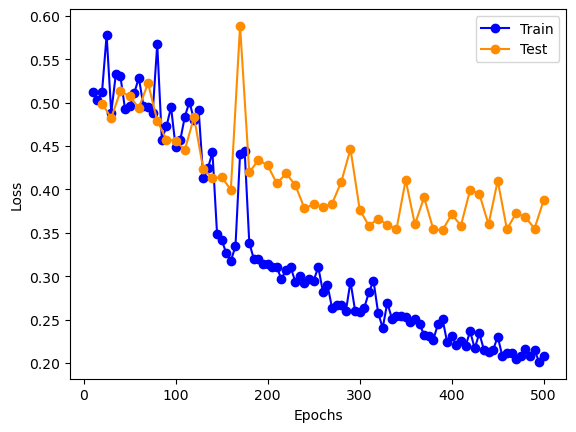

In [20]:
n=2
plt.plot(range(0,epochs,5)[n:], loss_train[n:], 'o-', label = 'Train', color = 'blue')
plt.plot(range(0,epochs,10)[n:], loss_test[n:], 'o-', label = 'Test', color = 'darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

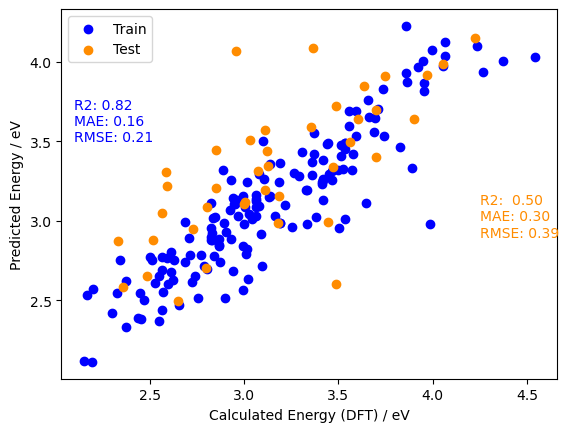

In [21]:
e = 5

plt.scatter(labels_train[e], pred_train[e], color = 'blue', label = 'Train')
plt.scatter(labels_test[e], pred_test[e], color = 'darkorange', label = 'Test')
plt.xlabel("Calculated Energy (DFT) / eV")
plt.ylabel("Predicted Energy / eV")
plt.legend()

plt.text(2.1, 3.5, f'R2: {pearsonr(labels_train[e], pred_train[e])[0]**2:.2f} \n\
MAE: {mean_absolute_error(labels_train[e], pred_train[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_train[e], pred_train[e])):.2f}', color = 'b')

plt.text(4.25, 2.9, f'R2:  {pearsonr(labels_test[e], pred_test[e])[0]**2:.2f}\n\
MAE: {mean_absolute_error(labels_test[e], pred_test[e]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_test[e], pred_test[e])):.2f}', color = 'darkorange')
plt.show()

In [22]:
def train_folds(kfold, epoch, model, optimiser, loader):

    all_preds = []
    all_y = []
    all_file = []
    total_loss = 0
    step = 0

    for batch in loader:

        # Use GPU
        batch.to(device)

        # Reset gradients
        optimiser.zero_grad()

        # Passing the node features and the connection info
        pred = model(batch.x.float(),  
                        batch.edge_index,
                        batch.batch)
        
        # Calculating the loss and gradients
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))
        loss.backward()

        # Update using the gradients
        optimiser.step() 

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_y.append(batch.y.cpu().detach().numpy())
        all_file.append(batch.file)
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    all_file = np.concatenate(all_file).ravel()
    
    return torch.tensor(total_loss/step), all_preds, all_labels, all_file

In [23]:
def test_folds(kfold, epoch, model, loader):
    
    all_preds = []
    all_labels = []
    all_file = []
    total_loss = 0
    step = 0

    for batch in loader:

        batch.to(device)
        pred = model(batch.x.float(),  
                        batch.edge_index, 
                        batch.batch)
        
        loss = torch.sqrt(loss_fn(pred, torch.unsqueeze(batch.y.float(), dim = 1)))

        total_loss += loss.item()
        step += 1

        all_preds.append(pred.cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
        all_file.append(batch.file)

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    all_file = np.concatenate(all_file).ravel()

    return torch.tensor(total_loss/step), all_preds, all_labels, all_file

In [24]:
epochs = 701

#folds x times loss is saved
loss_train_folds = np.zeros((len(train_idx), len(range(0, epochs,  5))))
loss_test_folds = np.zeros((len(train_idx), len(range(0, epochs,  10))))

#times preds are saved x number of predictions x folds
pred_train_folds = np.zeros((len(range(0, epochs, 100)), len(train_idx[0]), len(train_idx)))
pred_test_folds = np.zeros((len(range(0, epochs, 100)), len(test_idx[0]), len(train_idx)))

#times lables are saved x number of predictions x folds
labels_train_folds = np.zeros((len(range(0, epochs, 100)), len(train_idx[0]), len(train_idx)))
labels_test_folds = np.zeros((len(range(0, epochs, 100)), len(test_idx[0]), len(train_idx)))

#times file are saved x number of predictions x folds
file_train_folds = np.zeros((len(range(0, epochs, 100)), len(train_idx[0]), len(train_idx)))
file_test_folds = np.zeros((len(range(0, epochs, 100)), len(test_idx[0]), len(train_idx)))

In [25]:
loss_fn = torch.nn.MSELoss()
for fold in range(len(train_idx)):

    model = GCN_loop(data.num_features, embedding_size = 64, gnn_layers = 3, improved=False)
    loss_fn = torch.nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma = 0.995)
    train_loader = DataLoader(data[train_idx[fold]], batch_size = 20, shuffle = True) 
    test_loader = DataLoader(data[test_idx[fold]], batch_size = 10, shuffle = False) 


    for epoch in range (epochs):

        # Training
        model.train()
        loss, pred, label, file = train_folds(kfold = fold, 
                                        epoch=epoch, 
                                        model = model, 
                                        optimiser = optimiser, 
                                        loader = train_loader)
        
        loss = loss.detach().cpu().numpy()

        if epoch % 5 == 0:
            loss_train_folds[fold, int(epoch / 5)] = loss

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Fold {fold} | Train Loss {loss}")
            pred_train_folds[int(epoch/100), :, fold] = pred
            labels_train_folds[int(epoch/100), :, fold] = label
            file_train_folds[int(epoch/100), :, fold] = file


        # Testing
        model.eval()

        if epoch % 5 == 0:
            loss, pred, label, file = test_folds(kfold = fold, 
                                           epoch=epoch, 
                                           model=model,
                                           loader = test_loader)
            loss = loss.detach().cpu().numpy() 

            if epoch % 10 == 0:
                loss_test_folds[fold, int(epoch / 10)] = loss

            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Fold {fold} | Test Loss {loss}")
                pred_test_folds[int(epoch/100), :, fold] = pred
                labels_test_folds[int(epoch/100), :, fold] = label
                file_test_folds[int(epoch/100), :, fold] = file
        
        scheduler.step()
    
    print(f'Done for fold {fold}')

Epoch 0 | Fold 0 | Train Loss 1.0495316982269287
Epoch 0 | Fold 0 | Test Loss 0.5254753828048706
Epoch 100 | Fold 0 | Train Loss 0.4920674264431
Epoch 100 | Fold 0 | Test Loss 0.514974057674408
Epoch 200 | Fold 0 | Train Loss 0.4718531370162964
Epoch 200 | Fold 0 | Test Loss 0.48379752039909363
Epoch 300 | Fold 0 | Train Loss 0.2999952733516693
Epoch 300 | Fold 0 | Test Loss 0.33538010716438293
Epoch 400 | Fold 0 | Train Loss 0.27130118012428284
Epoch 400 | Fold 0 | Test Loss 0.3258831799030304
Epoch 500 | Fold 0 | Train Loss 0.20806080102920532
Epoch 500 | Fold 0 | Test Loss 0.30433550477027893
Epoch 600 | Fold 0 | Train Loss 0.18778260052204132
Epoch 600 | Fold 0 | Test Loss 0.28486141562461853
Epoch 700 | Fold 0 | Train Loss 0.1827099621295929
Epoch 700 | Fold 0 | Test Loss 0.2881604731082916
Done for fold 0
Epoch 0 | Fold 1 | Train Loss 1.0240931510925293
Epoch 0 | Fold 1 | Test Loss 0.47276777029037476
Epoch 100 | Fold 1 | Train Loss 0.4839674234390259
Epoch 100 | Fold 1 | Test Lo

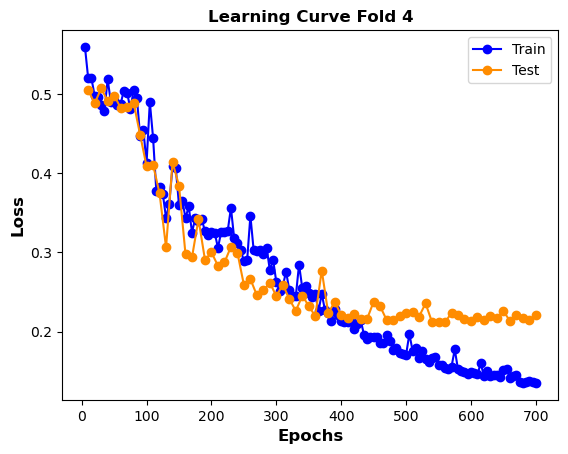

In [26]:
n=1
fold = 4

plt.plot(figsize =(3, 2))

plt.title(f'Learning Curve Fold {fold}', fontweight ='bold')

plt.plot(range(0,epochs,5)[n:], loss_train_folds[fold, n:], 'o-', label = 'Train', color = 'blue')
plt.plot(range(0,epochs,10)[n:], loss_test_folds[fold, n:], 'o-', label = 'Test', color = 'darkorange')
plt.xlabel('Epochs', fontweight ='bold', fontsize = 12)
plt.ylabel('Loss', fontweight ='bold', fontsize = 12)
plt.legend()
plt.show()

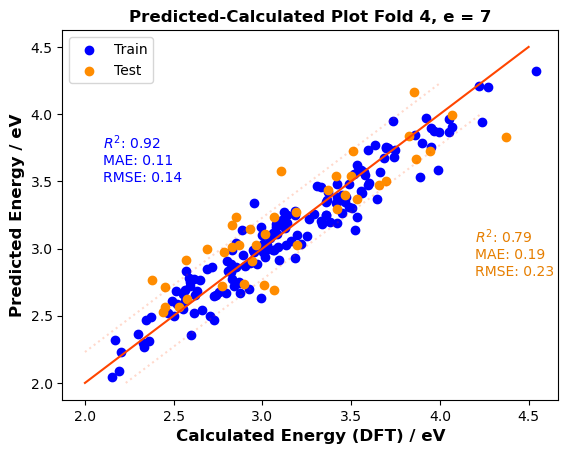

In [27]:
e = 7
fold = 4


plt.plot(figsize =(6, 4))

plt.title(f'Predicted-Calculated Plot Fold {fold}, e = {e}', fontweight ='bold')

plt.scatter(labels_train_folds[e,:,fold], pred_train_folds[e,:,fold], color = 'blue', label = 'Train')
plt.scatter(labels_test_folds[e,:,fold], pred_test_folds[e,:,fold], color = 'darkorange', label = 'Test')
plt.xlabel("Calculated Energy (DFT) / eV", fontweight ='bold', fontsize = 12)
plt.ylabel("Predicted Energy / eV", fontweight ='bold', fontsize = 12)
plt.legend()

plt.plot( [2, 4],[2+.23, 4+.23], color = 'orangered', ls = ':', alpha = .2 )

plt.plot( [2, 4.5],[2, 4.5], color = 'orangered' )

plt.plot( [2+.23, 4+.23],[2, 4], color = 'orangered', ls = ':', alpha = .2 )

plt.text(2.1, 3.5, f'$R^2$: {r2_score(labels_train_folds[e,:,fold],pred_train_folds[e,:,fold]):.2f} \n\
MAE: {mean_absolute_error(labels_train_folds[e,:,fold], pred_train_folds[e,:,fold]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_train_folds[e,:,fold], pred_train_folds[e,:,fold])):.2f}', color = 'b')

plt.text(4.2, 2.8, f'$R^2$: {r2_score(labels_test_folds[e,:,fold], pred_test_folds[e,:,fold]):.2f} \n\
MAE: {mean_absolute_error(labels_test_folds[e,:,fold], pred_test_folds[e,:,fold]):.2f} \n\
RMSE: {sqrt(mean_squared_error(labels_test_folds[e,:,fold], pred_test_folds[e,:,fold])):.2f}', color = '#e67e00')

plt.show()

In [28]:
e = 7
fold = 2

r_train = labels_train_folds[e,:,fold]
p_train = pred_train_folds[e,:,fold]
grad = pred_train_folds[e,:,fold] - labels_train_folds[e,:,fold]
files_train = file_train_folds[e,:,fold]

train_trace = go.Scatter(x=r_train,
                         y=p_train,
                         mode='markers',
                         name= 'Train set',
                         opacity=.7, 
                         hovertemplate = 
                         'Predicted: %{y:.2f}'+
                        '<br>Calculated: %{x:.2f}<br>'+
                        '%{text}',
                        text = ['File: {}.vasp'.format(int(i)) for i in files_train],
                         marker=dict(symbol='circle',
                                     size=5,
                                     color='black')
                            )


r_test = labels_test_folds[e,:,fold]
p_test = pred_test_folds[e,:,fold]
grad = pred_test_folds[e,:,fold] - labels_test_folds[e,:,fold]
files_test = file_test_folds[e,:,fold]

test_trace = go.Scatter(x=r_test,
                         y=p_test,
                         mode='markers',
                         name= 'Test set',
                         hovertemplate = 
                         '<i>Predicted</i>: %{y:.2f}'+
                        '<br>Calculated: %{x:.2f}<br>'+
                        '%{text}',
                        text = ['File: {}.vasp'.format(int(i)) for i in files_test],

                         marker=dict(symbol='circle',
                                     size=5,
                                     color=-abs(grad),
                                     colorscale='Hot')
                            )


trace_edges= go.Scatter(x=[min(labels_train_folds[e,:,fold]), max(labels_train_folds[e,:,fold])],
                        y=[min(labels_train_folds[e,:,fold]), max(labels_train_folds[e,:,fold])],
                        text='Identity line',
                        mode='lines',
                        name='Identity',
                        line=dict(color='black', width=1,dash='dash'),
                        hoverinfo='none')

traces = [train_trace, test_trace, trace_edges]

fig = go.Figure(data=traces)

fig.update_xaxes(title_text="Calculated DFT Energy / eV")
fig.update_yaxes(title_text="Predicted Energy / eV")

fig.update_layout(autosize=False,
    width=900,
    height=600, 
    template = 'none')

fig.show()

In [29]:
r2_global_test = []
for e in range(len(range(0,epochs,100))):
    r2_test = [pearsonr(labels_test_folds[e,:,f],pred_test_folds[e,:,f])[0]**2 
                  for f in range(len(train_idx))]
    r2_global_test.append(r2_test)
    
mae_global_test = []
for e in range(len(range(0,epochs,100))):
    mae_test = [mean_absolute_error(labels_test_folds[e,:,f],pred_test_folds[e,:,f])
                  for f in range(len(train_idx))]
    mae_global_test.append(mae_test)

rmse_global_test = []
for e in range(len(range(0,epochs,100))):
    rmse_test = [sqrt(mean_squared_error(labels_test_folds[e,:,f],pred_test_folds[e,:,f]))
                  for f in range(len(train_idx))]
    rmse_global_test.append(rmse_test)

In [30]:
mean_r2_test = []
std_r2_test = []

mean_mae_test = []
std_mae_test = []

mean_rmse_test = []
std_rmse_test = []

for i in range(len(range(0,epochs,100))):

    mean_r2_test.append(np.mean(r2_global_test[i]))
    std_r2_test.append(np.std(r2_global_test[i]))

    mean_mae_test.append(np.mean(mae_global_test[i]))
    std_mae_test.append(np.std(mae_global_test[i]))

    mean_rmse_test.append(np.mean(rmse_global_test[i]))
    std_rmse_test.append(np.std(rmse_global_test[i]))

In [31]:
print(f'e value for best R2: {mean_r2_test.index(max(mean_r2_test))}')
print(f'e value for best MAE: {mean_mae_test.index(min(mean_mae_test))}')
print(f'e value for best RMSE: {mean_rmse_test.index(min(mean_rmse_test))}')

e value for best R2: 7
e value for best MAE: 7
e value for best RMSE: 7


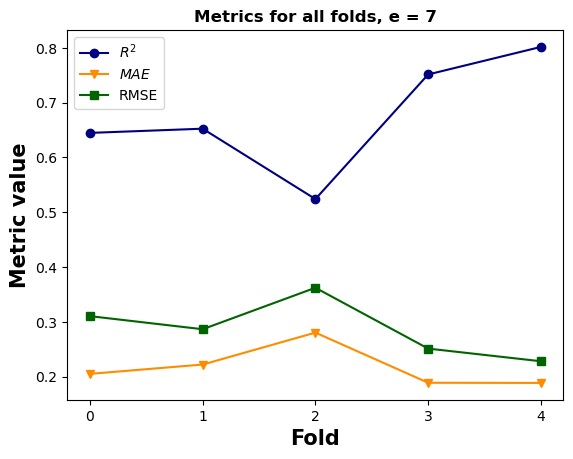

In [32]:
e = 7
plt.plot(figsize =(6, 4))

plt.title(f'Metrics for all folds, e = {e}', fontweight ='bold')

plt.plot(range(len(train_idx)), r2_global_test[e], 'o-', label = '$R^2$', color = 'navy')
plt.plot(range(len(train_idx)), mae_global_test[e], 'v-', label = '$MAE$', color = 'darkorange')
plt.plot(range(len(train_idx)), rmse_global_test[e], 's-', label = 'RMSE', color = 'darkgreen')
plt.xticks(range(len(train_idx)), range(5))

plt.xlabel('Fold', fontweight ='bold', fontsize = 15)
plt.ylabel('Metric value', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [33]:
Metrics = ['$R^2$', '$MAE$', '$RMSE$']
x_pos = np.arange(len(Metrics))
CTEs = [mean_r2_test[e], mean_mae_test[e], mean_rmse_test[e]]
error = [std_r2_test[e], std_mae_test[e], std_rmse_test[e]]
CTEs = [round(metric, 3) for metric in CTEs]

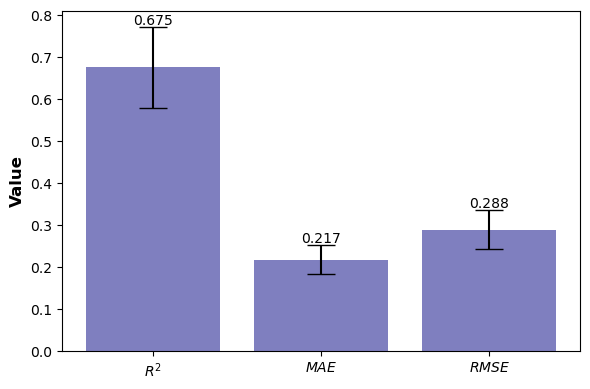

In [34]:
fig, ax = plt.subplots(figsize =(6, 4))
bars = ax.bar(x_pos, CTEs, yerr=error, align='center', color = 'navy', alpha=.5, ecolor='black', capsize=10)
ax.set_ylabel('Value', fontweight ='bold', fontsize = 12)
ax.bar_label(bars)
ax.set_xticks(x_pos)
ax.set_xticklabels(Metrics, fontweight ='bold' ,fontsize = 10)
ax.yaxis.grid(False)

plt.tight_layout()
plt.show()

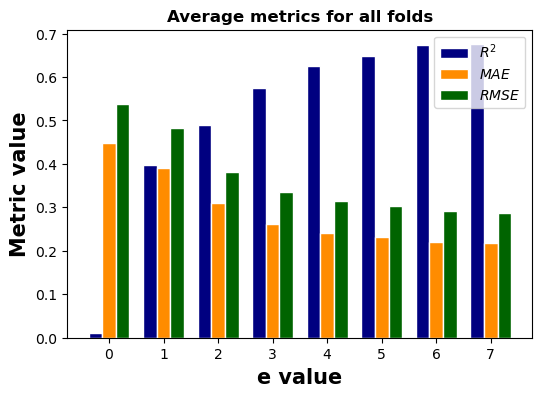

In [35]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(6, 4))

plt.title(f'Average metrics for all folds', fontweight ='bold')

# set height of bar
R2 = mean_r2_test
MAE = mean_mae_test
RMSE = mean_rmse_test
 
# Set position of bar on X axis
br1 = np.arange(len(R2))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, R2, color ='navy', width = barWidth,
        edgecolor ='white', label ='$R^2$')
plt.bar(br2, MAE, color ='darkorange', width = barWidth,
        edgecolor ='white', label ='$MAE$')
plt.bar(br3, RMSE, color ='darkgreen', width = barWidth,
        edgecolor ='white', label ='$RMSE$')
 
# Adding Xticks
plt.xlabel('e value', fontweight ='bold', fontsize = 15)
plt.ylabel('Metric value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(R2))],
        [i for i in range(len(R2))])
 
plt.legend()
plt.show()

In [36]:
best_r2 = r2_global_test[e]
best_mae = mae_global_test[e]
best_rmse = rmse_global_test[e]

In [37]:
df = pd.DataFrame(list(zip(best_r2, best_mae, best_rmse)), columns = ['R2', 'MAE', 'RMSE'])
max = pd.DataFrame(np.transpose(np.array(df.max()))).T
max.columns = df.columns
max = max.rename(index={0:'Max'})
min = pd.DataFrame(np.transpose(np.array(df.min()))).T
min.columns = df.columns
min = min.rename(index={0:'Min'})
mean = pd.DataFrame(np.transpose(np.array(df.mean()))).T
mean.columns = df.columns
mean = mean.rename(index={0:'Mean'})
std = pd.DataFrame(np.transpose(np.array(df.std()))).T
std.columns = df.columns
std = std.rename(index={0:'Std'})
df = pd.concat([df,max,min,mean,std], axis = 0)
df.index.name = 'fold'
df

,R2,MAE,RMSE
fold,,,
0,0.644858,0.205181,0.310479
1,0.652544,0.222152,0.286604
2,0.524117,0.280456,0.362297
3,0.751484,0.188945,0.251282
4,0.801750,0.188632,0.228177
Max,0.801750,0.280456,0.362297
Min,0.524117,0.188632,0.228177
Mean,0.674951,0.217073,0.287768
Std,0.107347,0.038029,0.052331
